<a href="https://colab.research.google.com/github/ikucherevsky/DeepLearning/blob/master/Probcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 https://arxiv.org/abs/2005.01181

## If You Like It, GAN It. Probabilistic Multivariate Times Series Forecast With GAN

https://arxiv.org/abs/2005.01181
Alireza Koochali, Andreas Dengel, Sheraz Ahmed

In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchvision import datasets,transforms
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Датасет для статьи
https://github.com/laiguokun/multivariate-time-series-data/archive/master.zip

In [ ]:
!wget -N https://github.com/laiguokun/multivariate-time-series-data/archive/master.zip
!unzip master.zip
!rm master.zip

--2020-05-22 23:42:24--  https://github.com/laiguokun/multivariate-time-series-data/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/laiguokun/multivariate-time-series-data/zip/master [following]
--2020-05-22 23:42:24--  https://codeload.github.com/laiguokun/multivariate-time-series-data/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   <=>              ]  53.18M  38.5MB/s    in 1.4s    

Last-modified header missing -- time-stamps turned off.
2020-05-22 23:42:26 (38.5 MB/s) - ‘master.zip’ saved [55763862]

Archive:  master.zip
7f402f185cc2435b5e66aed13

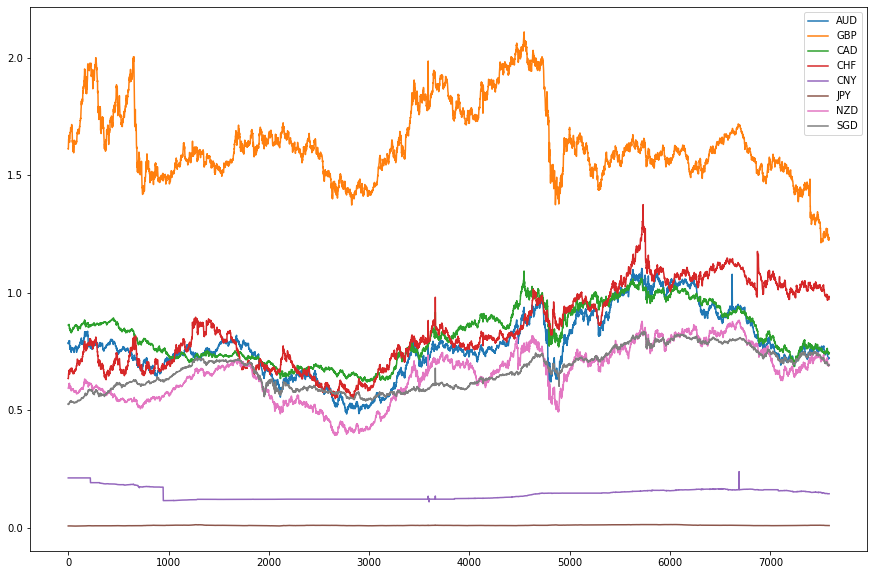

In [ ]:
el_df = pd.read_csv('/content/multivariate-time-series-data-master/electricity/electricity.txt.gz', header = None)
ex_df = pd.read_csv('/content/multivariate-time-series-data-master/exchange_rate/exchange_rate.txt.gz',header = None)
columns  = ['AUD','GBP','CAD','CHF','CNY','JPY','NZD','SGD']
ex_df.columns = columns
train = ex_df.iloc[:5000]
test = ex_df.iloc[5000:]
ex_df.plot(figsize=(15,10));

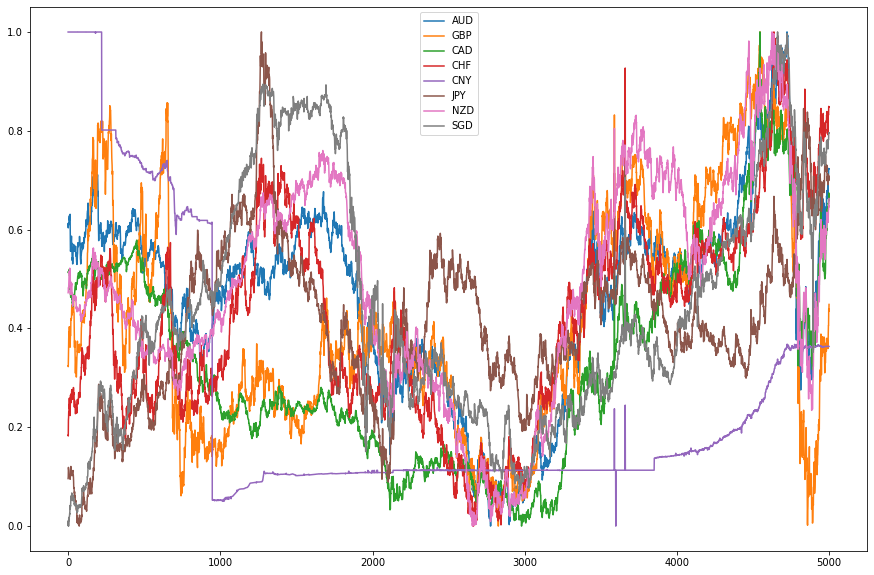

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
train = pd.DataFrame(scaler.transform(train), columns=columns)
test = pd.DataFrame(scaler.transform(test), columns=columns)
train.plot(figsize=(15,10));

In [ ]:
window_size = 90
BATCH_SIZE = 30
num_epochs = 100
num_features = 8
hidden_size = 180

In [ ]:
# функция для генерации кортежа (тренировочная последовательность длиной tw, истинное значение последовательности 
# в момент времени t+1)
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data.iloc[i:i+tw].to_numpy()
        train_seq = torch.FloatTensor(train_seq)
        train_label = input_data.iloc[i+tw:i+tw+1].to_numpy()
        train_label = torch.FloatTensor(train_label)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
TRAIN = create_inout_sequences(train, window_size)
TEST = create_inout_sequences(test, window_size) 
train_iter = torch.utils.data.DataLoader(TRAIN, batch_size=BATCH_SIZE, shuffle = True)
test_iter = torch.utils.data.DataLoader(TEST, batch_size=BATCH_SIZE, shuffle = True)


## Детерминированный генератор

In [ ]:
class Det_Generator(nn.Module):
  def __init__(self, g_in_dim, hidden_size, g_out_dim):
    super(Det_Generator,self).__init__()
    self.g_in_dim = g_in_dim
    self.g_out_dim = g_out_dim
    self.hidden_size = hidden_size
    self.gru = nn.GRU(g_in_dim, hidden_size, batch_first = True)
    self.d1 = nn.Dropout(0.2)
    self.fl = nn.Linear(hidden_size,hidden_size)
    self.d2 = nn.Dropout(0.2)
    self.sl = nn.Linear(hidden_size, g_out_dim)

 # def init_hidden(self, batch_size):

   # return torch.zeros(1,batch_size,self.hidden_size)

  def forward(self, sequence, hs):
    #batch_size, seq_len = sequence.size()
    
    lstm_out, hs = self.gru(sequence,hs)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
    x = self.d1(hs)
    x = self.fl(x)
    x = self.d2(x)
    x = self.sl(x)
    return x, hs


In [ ]:
# without hidden state 

class Det_Generator(nn.Module):
  def __init__(self, g_in_dim, hidden_size, g_out_dim):
    super(Det_Generator,self).__init__()
    self.g_in_dim = g_in_dim
    self.g_out_dim = g_out_dim
    self.hidden_size = hidden_size
    self.gru = nn.GRU(g_in_dim, hidden_size, batch_first = True)
    self.d1 = nn.Dropout(0.2)
    self.fl = nn.Linear(hidden_size,hidden_size)
    self.d2 = nn.Dropout(0.2)
    self.sl = nn.Linear(hidden_size, g_out_dim)

 # def init_hidden(self, batch_size):

   # return torch.zeros(1,batch_size,self.hidden_size)

  def forward(self, sequence,h):
    #batch_size, seq_len = sequence.size()
    
    lstm_out, hs = self.gru(sequence,h)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
    x = self.d1(hs)
    x = self.fl(x)
    x = self.d2(x)
    x = self.sl(x)
    return x


In [ ]:
model = Det_Generator(num_features,hidden_size,num_features)

In [ ]:
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
start_epoch = 0

In [ ]:
#Run this cell to download a previously saved model if you want to continue to train it
checkpoint = 'checkpoint_DetermGenerator.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']


In [ ]:
train_loss_line = []
test_loss_line = []
for ep in range(start_epoch + num_epochs):
  model.train()
  train_loss = 0
  test_loss = 0

  for x, y in train_iter:
    h = torch.zeros(1,BATCH_SIZE,180)
    optimizer.zero_grad()
    if x.size(0) != BATCH_SIZE:
      break
    optimizer.zero_grad()
    y_hat = model(x,h)
    #print(y.view(-1).size(),y_hat.size())
    loss = criterion(y_hat.view(-1), y.view(-1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # check model on test data
  h_test = torch.zeros(1,BATCH_SIZE,180)
  for x_test, y_test in test_iter:
    model.eval()
    h_test = torch.zeros(1,BATCH_SIZE,180)
    if x_test.size(0) != BATCH_SIZE:
      break
    y_hat_test = model(x_test,h_test)
    #print(y.view(-1).size(),y_hat.size())
    loss_t = criterion(y_hat_test.view(-1), y_test.view(-1))
    test_loss += loss_t.item()

  train_loss_line.append(train_loss)
  test_loss_line.append(test_loss)
  save_checkpoint(ep, model, optimizer)
  print(f'step :   {ep}  train loss :  {train_loss} test loss :  {test_loss * 1.5}')   

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Det_Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


step :   0  train loss :  1.28562554391101 test loss :  1.5849038762971759
step :   1  train loss :  0.26650076516671106 test loss :  0.295228005386889
step :   2  train loss :  0.18998074642149732 test loss :  0.3392318057594821
step :   3  train loss :  0.16587775072548538 test loss :  0.20037621416850016
step :   4  train loss :  0.14946916385088116 test loss :  0.16121201257919893
step :   5  train loss :  0.1442220654571429 test loss :  0.2862059036269784
step :   6  train loss :  0.13287734956247732 test loss :  0.05940712447045371
step :   7  train loss :  0.1262200224737171 test loss :  0.19020811468362808
step :   8  train loss :  0.1254624760185834 test loss :  0.09614392288494855
step :   9  train loss :  0.1172093058412429 test loss :  0.06388701243849937
step :   10  train loss :  0.1090864118305035 test loss :  0.1020462277228944
step :   11  train loss :  0.11015475436579436 test loss :  0.15946879325201735
step :   12  train loss :  0.10868822483462282 test loss :  0.11

KeyboardInterrupt: ignored

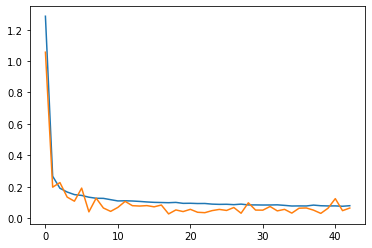

In [ ]:
plt.plot(train_loss_line);
plt.plot(test_loss_line);

In [ ]:
def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_DetermGenerator.pth.tar'
    torch.save(state, filename)

In [ ]:
# Load model checkpoint
checkpoint = 'checkpoint_DetermGenerator.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']


Loaded checkpoint from epoch 43.



## Визуализация предсказаний сети 


In [ ]:
start_point = 3000
forecast_len = 15

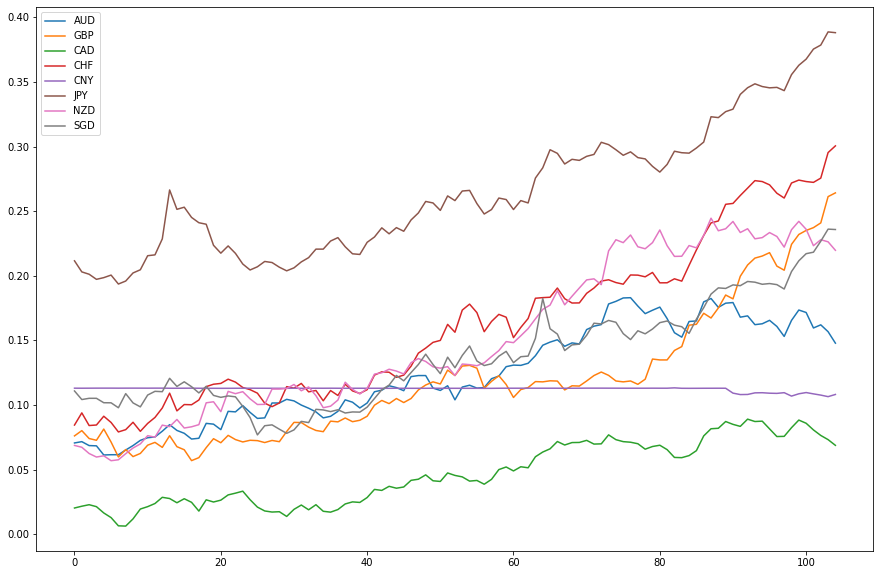

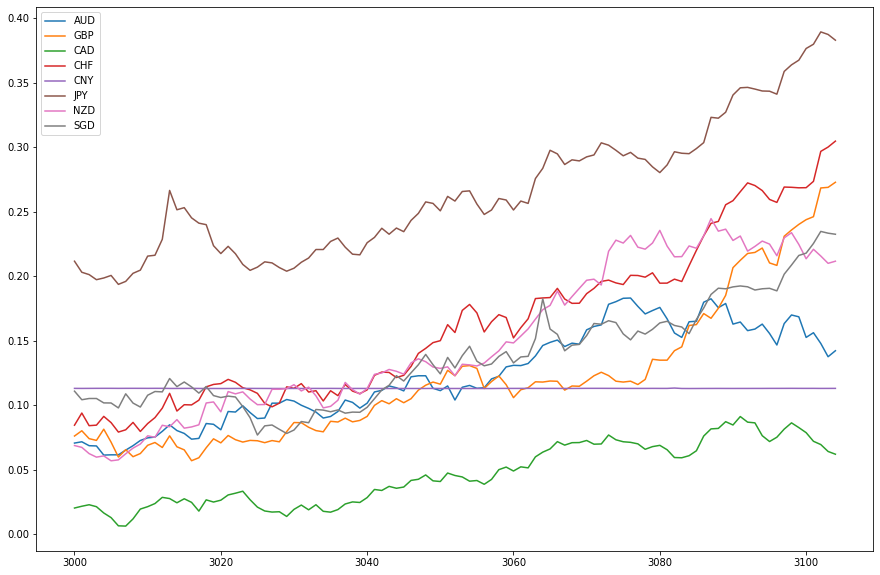

In [ ]:
# предсказание на 1 шаг вперед с подкреплением настоящими значениями на каждом новом предсказании
model.eval()
hid = torch.zeros(1,1,180)
start_seq = np.array(train.iloc[start_point:start_point + window_size])
start_seq = torch.tensor(start_seq, dtype= torch.float32)
result = model(start_seq.unsqueeze(0),hid)
result = result.detach()
hid = hid.detach()
result = result.reshape(1,-1)
start_seq = torch.cat([start_seq, result], dim = 0)
for i in range(1,forecast_len):
  seq = np.array(train.iloc[start_point + i:start_point + window_size + i])
  seq = torch.tensor(seq, dtype= torch.float32)
  result = model(seq.unsqueeze(0),hid)
  result = result.detach()
  hid = hid.detach()
  result = result.reshape(1,-1)
  start_seq = torch.cat([start_seq, result], dim = 0)
FCST = pd.DataFrame(start_seq.numpy(), columns = columns)
FCST.plot(figsize=(15,10));
train[start_point:start_point + window_size + forecast_len].plot(figsize=(15,10));

In [ ]:
# предсказание на 1 шаг вперед без подкрепления настоящими значениями на каждом новом предсказании
#
model.eval()
hid = torch.zeros(1,1,180)
start_seq = np.array(train.iloc[start_point:start_point + window_size])
start_seq = torch.tensor(start_seq, dtype= torch.float32)
result = model(start_seq.unsqueeze(0),hid)
result = result.detach()
hid = hid.detach()
result = result.reshape(1,-1)
start_seq = torch.cat([start_seq, result], dim = 0)
for i in range(1,forecast_len):
  seq = np.array(train.iloc[start_point + i:start_point + window_size + i])
  seq = torch.tensor(seq, dtype= torch.float32)
  result = model(seq.unsqueeze(0),hid)
  result = result.detach()
  hid = hid.detach()
  result = result.reshape(1,-1)
  start_seq = torch.cat([start_seq, result], dim = 0)
FCST = pd.DataFrame(start_seq.numpy(), columns = columns)
FCST.plot(figsize=(15,10));
train[start_point:start_point + window_size + forecast_len].plot(figsize=(15,10));

## Генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

In [ ]:
z_dim = 200
anime_dim = 4096*3

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(dev)
D = Discriminator(anime_dim).to(dev)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, anime_dim), torch.ones(BATCH_SIZE, 1)
    x_real, y_real = torch.autograd.Variable(x_real.to(dev)), torch.autograd.Variable(y_real.to(dev))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    x_fake, y_fake = G(z), torch.autograd.Variable(torch.zeros(BATCH_SIZE, 1).to(dev))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.autograd.Variable(torch.randn(BATCH_SIZE, z_dim).to(dev))
    y = torch.autograd.Variable(torch.ones(BATCH_SIZE, 1).to(dev))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for x, _ in train_iter:
        if len(x) != BATCH_SIZE:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/100]: loss_d: 0.112, loss_g: 3.735
[2/100]: loss_d: 0.105, loss_g: 3.919
[3/100]: loss_d: 0.085, loss_g: 4.295
[4/100]: loss_d: 0.062, loss_g: 4.681
[5/100]: loss_d: 0.060, loss_g: 4.833
[6/100]: loss_d: 0.050, loss_g: 5.004
[7/100]: loss_d: 0.038, loss_g: 5.328
[8/100]: loss_d: 0.038, loss_g: 5.562
[9/100]: loss_d: 0.032, loss_g: 5.846
[10/100]: loss_d: 0.036, loss_g: 5.967
[11/100]: loss_d: 0.029, loss_g: 6.231
[12/100]: loss_d: 0.035, loss_g: 6.421
[13/100]: loss_d: 0.029, loss_g: 6.496
[14/100]: loss_d: 0.023, loss_g: 6.777
[15/100]: loss_d: 0.037, loss_g: 6.853
[16/100]: loss_d: 0.093, loss_g: 6.804
[17/100]: loss_d: 0.021, loss_g: 6.662
[18/100]: loss_d: 0.020, loss_g: 6.761
[19/100]: loss_d: 0.049, loss_g: 7.134
[20/100]: loss_d: 0.023, loss_g: 7.160
[21/100]: loss_d: 0.019, loss_g: 7.142
[22/100]: loss_d: 0.044, loss_g: 7.467
[23/100]: loss_d: 0.020, loss_g: 7.240
[24/100]: loss_d: 0.042, loss_g: 7.736
[25/100]: loss_d: 0.028, loss_g: 7.647
[26/100]: loss_d: 0.015, loss_g: 7

In [ ]:
test_z = torch.autograd.Variable(torch.randn(15, z_dim).to(dev))
generated = G(test_z)

In [ ]:
generated.shape

torch.Size([15, 12288])

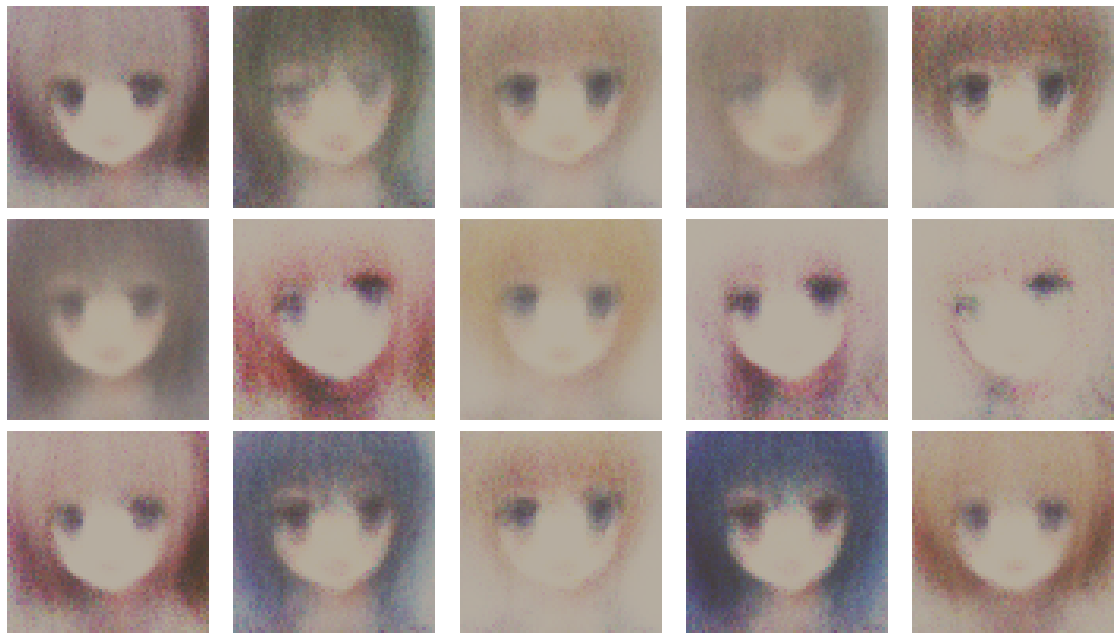

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(3):
    plt.subplot(3, 5, y * 5 + x + 1)
    plt.axis('off')
    inp = generated[y * 5 + x].cpu().detach()
    inp = inp.view(3,64,64)
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
plt.tight_layout()
plt.show()